# **ATTACKS.PY**

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import random

########## Fast Gradient Sign Method attack ####################################
### model : the network to attack
### x : the vanilla inputs
### y : the true classes (untargeted) / the target classes (targeted)
### eps : the stepsize
### targeted : wether to use the targeted attack or not
def attack_FGSM(model, x, y, eps, targeted=False):
    model.eval()            # We put the model in eval mode to avoid any stochasticity
    x.requires_grad_(True)  # We track the gradients of the input

    logits = model(torch.clamp(x,0,1))
    loss   = F.cross_entropy(logits, y)
    loss.backward()

    if not targeted:    x_adv  = x.detach() + eps * torch.sign(x.grad)  # We increase the loss wrt true classes
    else:               x_adv  = x.detach() - eps * torch.sign(x.grad)  # We decrease the loss wrt target classes

    x = x.detach()
    model.zero_grad()
    return x_adv.detach()


########## Projects points onto the lp-norm if outside ###########
### x : points to be projected
### eps : radius of norm-ball
### p : Lp norm of ball
def project(x, eps, p=2):
    if p=="inf":
        x = torch.clamp(x,-eps,eps)
    else:
        norms = torch.norm(x.view(x.size(0),-1),dim=1,p=p)
        norms[norms==0] = 1                          # To avoid division by zero
        mask  = (norms > eps)                        # We select only inputs of the batch with a norm > eps
        x[mask] /= norms[mask].view(-1,1,1,1)        # Project onto p-norm ball of radius 1
        x[mask] *= eps                               # Multiply by eps
    return x

########## Projected Gradient Descent attack ###################################
### model : the network to attack
### x : the vanilla inputs
### y : the true classes (untargeted) / the target classes (targeted)
### eps : the radius of the norm-ball in which we want our perturbation
### stepsize : the stepsize
### iterations : the number of iterations
### p : the norm to use (l2, linf...)
### targeted : wether to use the targeted attack or not
def attack_PGD(model, x, y, eps, stepsize, iterations, p=2, targeted=False):
    model.eval()  # We put the model in eval mode to avoid any stochasticity

    # Start with a random point inside norm-ball
    if p=="inf":
        delta = (torch.rand(x.size()) * 2 - 1) * eps    # Each values ~ uniform(-eps,eps)
    else:
        delta = torch.randn_like(x)                                             # Generate random direction
        norms = torch.norm(delta.view(delta.size(0),-1), dim=1, p=p)
        norms[norms==0] = 1                                                     # To avoid division by zero
        delta /= norms.view(-1,1,1,1)                                           # Project onto p-norm ball of radius 1
        delta *= torch.rand((delta.size(0),1,1,1)).to(device) * eps                        # Multiply each value by f ~ uniform(0,eps)

    delta = delta.to(device)
    # Iterately take a step of fixed norm, the project on p-norm ball if necessary
    for i in range(iterations):
        x_adv = x + delta
        x_adv.requires_grad_(True)
        logits = model(torch.clamp(x_adv,0,1))
        loss   = F.cross_entropy(logits,y)
        loss.backward()

        # Update image with a fixed stepsize
        if p=="inf":
            gradient = torch.sign(x_adv.grad) * stepsize
        else:
            gradient  = x_adv.grad                                                # Take the gradient direction
            norms     = torch.norm(gradient.view(gradient.size(0),-1),dim=1,p=p)
            norms[norms==0] = 1                                                   # To avoid division by zero
            gradient /= norms.view(-1,1,1,1)                                      # Project onto p-norm ball of radius 1
            gradient *= stepsize                                                  # Multipy by stepsize

        if not targeted :   x_adv = x_adv.detach() + gradient 
        else:               x_adv = x_adv.detach() - gradient

        # Project delta onto p-norm ball of radius eps if necessary
        delta = (x_adv - x).detach()
        delta = project(delta, eps, p)

    x = x.detach()
    model.zero_grad()
    return torch.clamp(x + delta,0,1)

# **MODEL.py**

In [ ]:
#!/usr/bin/env python3 
import os
import argparse
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import * 
import torch.utils.data
import torchvision.transforms as transforms

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

valid_size = 1024 
batch_size = 128

class Net(nn.Module):

    model_file="models/default_model.pth"

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)  # 32 * 32
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) # 16 * 16
        self.conv3 = nn.Conv2d(64, 64, 5, padding=2) # 8 * 8
        self.fc1 = nn.Linear(64 * 8 * 8, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1  = nn.BatchNorm2d(32)
        self.bn2  = nn.BatchNorm2d(64)
        self.bn3  = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def save(self, model_file):
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device)))

        
    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.
           
           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''        
        self.load(os.path.join(project_dir, Net.model_file))

def train_model(net, train_loader, pth_filename, num_epochs, adv=""):
    '''Basic training function (TODO)'''
    print("Starting training")
    optimizer = optim.SGD(net.parameters(),lr=0.1, momentum=0.0005)

    ############################################################################################################
    scheduler = CosineAnnealingLR(optimizer, num_epochs, eta_min=0)
    if os.path.exists(path+"models/checkpoint_scheduler.pth"):   
      net.load(pth_filename)
      scheduler.load_state_dict(torch.load(path+"models/checkpoint_scheduler.pth"))
      optimizer.load_state_dict(torch.load(path+"models/checkpoint_optimizer.pth"))
      last_epoch = scheduler.last_epoch
    else:                                         
      last_epoch = 0
    ############################################################################################################

    mean_loss   = 0
    mean_norm   = 0
    batch_count = 0

    net.train()

    for epoch in range(last_epoch, num_epochs):  # loop over the dataset multiple times

        for param_group in optimizer.param_groups:
          print(f"Learning Rate : {param_group['lr']}")

        print("--- Training epoch {}".format(epoch))
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            norm = None
            loss = None
            ############################################################################################################
            if adv=="PGD":
              inputs = attack_PGD(net,inputs,labels,10/255,2/255,10,"inf",False)
              net.train()
            elif adv=="Gradients":
              norm = None 
              loss = None
              inputs.requires_grad_(True)
              optimizer.zero_grad()
              grad, = torch.autograd.grad(F.cross_entropy(net(inputs),labels), inputs, create_graph=True)
              loss  = F.cross_entropy(net(inputs.detach()),labels)
              norm  = torch.norm(grad,p=2)
              total_loss = loss + 1000 * norm**2
              total_loss.backward()
              optimizer.step()
              inputs.requires_grad_(False)
            ############################################################################################################

            if adv!="Gradients":
              optimizer.zero_grad()
              logits = net(inputs)
              loss   = F.cross_entropy(logits,labels)
              loss.backward()
              optimizer.step()

            mean_loss   += loss.detach().item()
            if adv=="Gradients":
              mean_norm   += norm.detach().item()
            batch_count += 1
            if (batch_count % 10 == 0):
              print(f"* Batch {i+1}/{len(train_loader)} : {mean_loss/batch_count}")
              mean_loss   = 0
              batch_count = 0

        ###########################################################
        scheduler.step()
        net.save(pth_filename)
        print('Model saved in {}'.format(pth_filename))
        torch.save(scheduler.state_dict(), path+"models/checkpoint_scheduler.pth")
        torch.save(optimizer.state_dict(), path+"models/checkpoint_optimizer.pth")
        ###########################################################


    net.save(pth_filename)
    print('Model saved in {}'.format(pth_filename))
    os.remove(path+"models/checkpoint_scheduler.pth")
    os.remove(path+"models/checkpoint_optimizer.pth")

def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i,data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def test_adv(net, test_loader, attack_fn):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for i,data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)

        images_adv = attack_fn(net, images, labels)

        # calculate outputs by running images through the network
        outputs = net(images_adv)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total

def get_train_loader(dataset, valid_size=1024, batch_size=128):
    '''Split dataset into [train:valid] and return a DataLoader for the training part.'''

    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    return train

def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the validation part.'''

    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

    return valid

def main(model_name="model", epochs=100, method=""):

    '''
    #### Parse command line arguments 
    parser = argparse.ArgumentParser()
    parser.add_argument("--model-file", default=Net.model_file,
                        help="Name of the file used to load or to sore the model weights."\
                        "If the file exists, the weights will be load from it."\
                        "If the file doesn't exists, or if --force-train is set, training will be performed, "\
                        "and the model weights will be stored in this file."\
                        "Warning: "+Net.model_file+" will be used for testing (see load_for_testing()).")
    parser.add_argument('-f', '--force-train', action="store_true",
                        help="Force training even if model file already exists"\
                             "Warning: previous model file will be erased!).")
    parser.add_argument('-e', '--num-epochs', type=int, default=10,
                        help="Set the number of epochs during training")
    args = parser.parse_args()
    '''

    class Args:

      def __init__(self, mf,ft,ne):
        self.model_file=mf
        self.force_train=ft
        self.num_epochs=ne

    args = Args("models/"+model_name+".pth",True,epochs)

    #### Create model and move it to whatever device is available (gpu/cpu)
    net = Net()
    net.to(device)

    #### Model training (if necessary)
    if not os.path.exists(args.model_file) or args.force_train:
        print("Training model")
        print(args.model_file)

        train_transform = transforms.Compose([ transforms.RandomHorizontalFlip(),   
                                               transforms.RandomCrop(size=32, padding=4), 
                                               transforms.ToTensor()]) 
        
        cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
        train_loader = get_train_loader(cifar, valid_size, batch_size=batch_size)
        train_model(net, train_loader, args.model_file, args.num_epochs,method)
        print("Model save to '{}'.".format(args.model_file))

    #### Model testing
    print("Testing with model from '{}'. ".format(args.model_file))

    # Note: You should not change the transform applied to the
    # validation dataset since, it will be the only transform used
    # during final testing.
    cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor()) 
    valid_loader = get_validation_loader(cifar, valid_size)

    net.load(args.model_file)

    acc = test_natural(net, valid_loader)
    print("Model natural accuracy (valid): {}".format(acc))

    if args.model_file != Net.model_file:
        print("Warning: '{0}' is not the default model file, "\
              "it will not be the one used for testing your project. "\
              "If this is your best model, "\
              "you should rename/link '{0}' to '{1}'.".format(args.model_file, Net.model_file))
'''
if __name__ == "__main__":
    main()
'''

'\nif __name__ == "__main__":\n    main()\n'

In [ ]:
main("vanilla",100,method="")
main("robust",100,method="PGD")
main("gradients",100,method="Gradients")

# **EVALUATION**

In [ ]:
import matplotlib.pyplot as plt

# VANILLA MODEL
net = Net()
net.to(device)
net.load("models/vanilla.pth")

# AVD. TRAIN. MODEL
net_adv = Net()
net_adv.to(device)
net_adv.load("models/robust.pth")

# GRADIENT NORM MIN. MODEL
net_grad = Net()
net_grad.to(device)
net_grad.load("models/gradients.pth")

cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor()) 
valid_loader = get_validation_loader(cifar, 1024)

In [ ]:
def get_graph(model, epsilons, attack):
  accuracies = []
  for eps in epsilons:
    if attack == "FGSM":      attack_fn = (lambda n,i,l : attack_FGSM(n,i,l,eps,False))
    elif attack == "PGD-l2":  attack_fn = (lambda n,i,l : attack_PGD(n,i,l,eps,eps/10,10,2,False))
    else:                     attack_fn = (lambda n,i,l : attack_PGD(n,i,l,eps,eps/10,10,"inf",False))
    acc = test_adv(model, valid_loader, attack_fn)
    accuracies.append(acc)

  return accuracies

In [ ]:
epsilons = [i*0.01 for i in range(21)]
accuracies_normal = get_graph(net, epsilons, "FGSM")
accuracies_adv    = get_graph(net_adv, epsilons, "FGSM")
accuracies_grad   = get_graph(net_grad, epsilons, "FGSM")

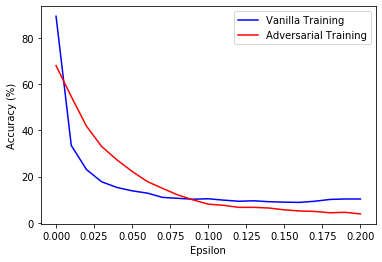

In [ ]:
plt.plot(epsilons, accuracies_normal, color="b", label="Vanilla Training")
plt.plot(epsilons, accuracies_adv, color="r", label="Adversarial Training")
#plt.plot(epsilons, accuracies_grad, color="g", label="Gradient Minimization")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epsilon")
plt.legend()
plt.show()

In [ ]:
epsilons = [i*0.1 for i in range(21)]
accuracies_normal = get_graph(net, epsilons, "PGD-l2")
accuracies_adv    = get_graph(net_adv, epsilons, "PGD-l2")
accuracies_grad   = get_graph(net_grad, epsilons, "PGD-l2")

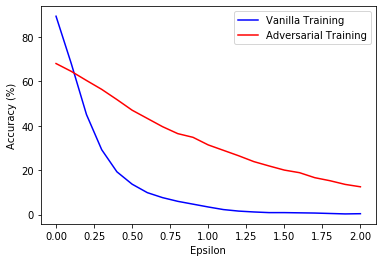

In [ ]:
plt.plot(epsilons, accuracies_normal, color="b", label="Vanilla Training")
plt.plot(epsilons, accuracies_adv, color="r", label="Adversarial Training")
#plt.plot(epsilons, accuracies_grad, color="g", label="Gradient Minimization")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epsilon")
plt.legend()
plt.show()

In [ ]:
epsilons = [i*0.01 for i in range(21)]
accuracies_normal = get_graph(net, epsilons, "PGD-linf")
accuracies_adv    = get_graph(net_adv, epsilons, "PGD-linf")
accuracies_grad   = get_graph(net_grad, epsilons, "PGD-linf")

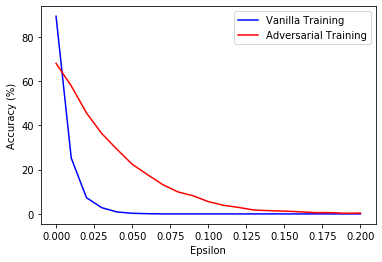

In [ ]:
plt.plot(epsilons, accuracies_normal, color="b", label="Vanilla Training")
plt.plot(epsilons, accuracies_adv, color="r", label="Adversarial Training")
#plt.plot(epsilons, accuracies_grad, color="g", label="Gradient Minimization")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epsilon")
plt.legend()
plt.show()